# Initial Load Config

In [19]:
import pandas as pd
import boto3
import numpy as np
from io import BytesIO

MAX_SENTENCE_LENGTH_IN_CHARS = 4500

session = boto3.Session(profile_name='kranio')
s3 = session.client('s3')
comprehend_client = session.client('comprehend')

In [20]:
bucket = "kranio-datalake"
key = "internal/webinar/leoCamilo/raw/complaints.csv"

obj = s3.get_object(Bucket=bucket, Key=key)
obj = BytesIO(obj['Body'].read())

df_source = pd.read_csv(obj)

# Exploratory Analysis

In [21]:
df_source.head()

,Ticket #,Customer Complaint,Date,Time,Received Via,City,State,Zip code,Status,Filing on Behalf of Someone,Description
0,250635,Comcast Cable Internet Speeds,4/22/2015,3:53:50 PM,Internet,Abingdon,Maryland,21009,Closed,No,I have been contacting Comcast Internet Techni...
1,223441,Payment disappear - service got disconnected,4/8/2015,10:22:56 AM,Internet,Acworth,Georgia,30102,Closed,No,Back in January 2015 I made 2 payments: One fo...
2,242732,Speed and Service,4/18/2015,9:55:47 AM,Internet,Acworth,Georgia,30101,Closed,Yes,Our home is located at in Acworth Georgia 3010...
3,277946,Comcast Imposed a New Usage Cap of 300GB that ...,5/7/2015,11:59:35 AM,Internet,Acworth,Georgia,30101,Open,Yes,Comcast in the Atlanta area has just put into ...
4,307175,Comcast not working and no service to boot,5/26/2015,1:25:26 PM,Internet,Acworth,Georgia,30101,Solved,No,I have been a customer of Comcast of some sort...


### Select Columns

In [22]:
df = df_source[["Ticket #", "Customer Complaint", "City", "State", "Status", "Description"]].copy()

In [23]:
df.head()

,Ticket #,Customer Complaint,City,State,Status,Description
0,250635,Comcast Cable Internet Speeds,Abingdon,Maryland,Closed,I have been contacting Comcast Internet Techni...
1,223441,Payment disappear - service got disconnected,Acworth,Georgia,Closed,Back in January 2015 I made 2 payments: One fo...
2,242732,Speed and Service,Acworth,Georgia,Closed,Our home is located at in Acworth Georgia 3010...
3,277946,Comcast Imposed a New Usage Cap of 300GB that ...,Acworth,Georgia,Open,Comcast in the Atlanta area has just put into ...
4,307175,Comcast not working and no service to boot,Acworth,Georgia,Solved,I have been a customer of Comcast of some sort...


### Add sentiment columns

In [24]:
df['Sentiment'] = ''
df['Positive'] = 0.0
df['Negative'] = 0.0
df['Neutral'] = 0.0
df['Mixed'] = 0.0

### Truncate Text to the limit of comprehend

In [25]:
df["TextToBeAnalyzed"] = df["Description"].str[:MAX_SENTENCE_LENGTH_IN_CHARS]

### Split DataFrame to the limit of comprehend

In [26]:
(rows, _) = df.shape
splitted_dataframe = np.array_split(df, rows / 23)

### Get Sentiment Result

In [27]:
def get_sentiment_analysis_batch(text_list):
    response = comprehend_client.batch_detect_sentiment(TextList=text_list, LanguageCode='en')

    comprehend_result = pd.DataFrame(response["ResultList"])
    sentiment_score = comprehend_result["SentimentScore"].apply(pd.Series)

    comprehend_result = comprehend_result[["Sentiment"]].merge(sentiment_score, left_index=True, right_index=True)

    return comprehend_result

In [28]:
df_result = pd.DataFrame()

for dataframe in splitted_dataframe:
    dataframe_selected = dataframe.reset_index().copy()
    text_list = dataframe_selected["TextToBeAnalyzed"].tolist()

    comprehend_result = get_sentiment_analysis_batch(text_list)
    
    dataframe_selected['Sentiment'] = comprehend_result['Sentiment']
    dataframe_selected['Positive'] = comprehend_result['Positive']
    dataframe_selected['Negative'] = comprehend_result['Negative']
    dataframe_selected['Neutral'] = comprehend_result['Neutral']
    dataframe_selected['Mixed'] = comprehend_result['Mixed']
    
    df_result = pd.concat([df_result, dataframe_selected], ignore_index=True)

### Select columns from result

In [29]:
df_result = df_result[[
    "Ticket #",
    "Customer Complaint",
    "City",
    "State",
    "Status",
    "Description",
    "Sentiment",
    "Negative",
    "Positive",
    "Neutral",
    "Mixed"
]]

In [30]:
df_result.head()

,Ticket #,Customer Complaint,City,State,Status,Description,Sentiment,Negative,Positive,Neutral,Mixed
0,250635,Comcast Cable Internet Speeds,Abingdon,Maryland,Closed,I have been contacting Comcast Internet Techni...,NEGATIVE,0.990655,0.007087,0.002257,0.000002
1,223441,Payment disappear - service got disconnected,Acworth,Georgia,Closed,Back in January 2015 I made 2 payments: One fo...,NEGATIVE,0.707160,0.157704,0.132487,0.002649
2,242732,Speed and Service,Acworth,Georgia,Closed,Our home is located at in Acworth Georgia 3010...,NEGATIVE,0.434039,0.306976,0.258934,0.000051
3,277946,Comcast Imposed a New Usage Cap of 300GB that ...,Acworth,Georgia,Open,Comcast in the Atlanta area has just put into ...,NEGATIVE,0.893312,0.079021,0.027510,0.000158
4,307175,Comcast not working and no service to boot,Acworth,Georgia,Solved,I have been a customer of Comcast of some sort...,NEGATIVE,0.997922,0.000983,0.001094,0.000002


### Group tickets by sentiments

In [31]:
df_result_grouped_sentiments = df_result[["Ticket #", "Sentiment"]].groupby(['Sentiment'], as_index=False).count()

In [32]:
df_result_grouped_sentiments

,Sentiment,Ticket #
0,MIXED,11
1,NEGATIVE,1804
2,NEUTRAL,289
3,POSITIVE,121


### Group tickets by city, state and sentiments

In [46]:
df_group_city_state_sentiments = df_result[["Ticket #", "City", "State", "Sentiment"]]
group_columns = ['City', 'State', 'Sentiment']

df_group_city_state_sentiments = df_group_city_state_sentiments.groupby(group_columns, as_index=False)
df_group_city_state_sentiments = df_group_city_state_sentiments.count()
df_group_city_state_sentiments = df_group_city_state_sentiments.sort_values(by=["Ticket #"], ascending=False)

In [47]:
df_group_city_state_sentiments

,City,State,Sentiment,Ticket #
35,Atlanta,Georgia,NEGATIVE,51
194,Chicago,Illinois,NEGATIVE,44
543,Knoxville,Tennessee,NEGATIVE,29
506,Jacksonville,Florida,NEGATIVE,27
483,Houston,Texas,NEGATIVE,25
...,...,...,...,...
511,Jensen Beach,Florida,NEGATIVE,1
513,Jesup,Georgia,NEGATIVE,1
514,Jesup,Georgia,POSITIVE,1
515,Joelton,Tennessee,NEUTRAL,1


# Results

### Tickets by sentiments

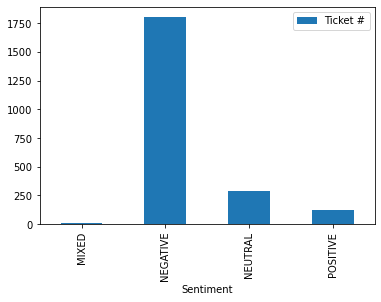

In [35]:
df_result_grouped_sentiments.set_index('Sentiment').plot(kind="bar")

### Top 5 Cities with negative sentiments

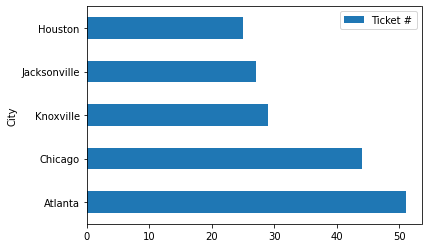

In [53]:
tmp_df = df_group_city_state_sentiments.head(5)
tmp_df = tmp_df.set_index('City')
tmp_df.plot(kind="barh")

In [60]:
df_states_sentiment = df_result[["Ticket #", "State", "Sentiment"]].groupby(['Sentiment', 'State'], as_index=False).count()
df_states_sentiment = df_states_sentiment.sort_values(by=["Ticket #"], ascending=False)
df_states_sentiment

,Sentiment,State,Ticket #
18,NEGATIVE,Georgia,236
17,NEGATIVE,Florida,207
11,NEGATIVE,California,171
19,NEGATIVE,Illinois,145
42,NEGATIVE,Tennessee,110
...,...,...,...
59,NEUTRAL,Indiana,1
61,NEUTRAL,Louisiana,1
68,NEUTRAL,Nevada,1
72,NEUTRAL,New York,1


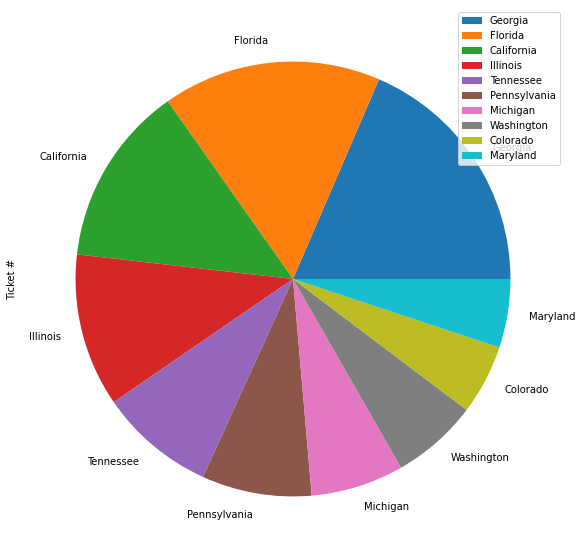

In [70]:
negative_idx = df_states_sentiment['Sentiment'] == 'NEGATIVE'
tmp_df = df_states_sentiment[negative_idx].head(10)
tmp_df = tmp_df.set_index('State')
tmp_df.plot.pie(y='Ticket #', figsize=(10, 10))